In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: pho
"""
%load_ext autoreload
%autoreload 2
import sys
import importlib
from copy import deepcopy
from threading import Thread
import time # for time.sleep
from ipygany import PolyMesh, Scene, IsoColor, WarpByScalar
import pyvista as pv
# from pyvista import _vtk
import pyvistaqt as pvqt
import colorcet as cc # Colormaps:
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage
from pathlib import Path
import bqplot.scales
import seaborn as sns
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
# import mplcursors
import math # For color map generation
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv

import ipywidgets as widgets
# from PyQt5 import QtWidgets, uic
from pyvistaqt import QtInteractor, MainWindow
# from pyqt6 import QApplication
from IPython.external.qt_for_kernel import QtGui
from PyQt5.QtWidgets import QApplication

import datetime as dt
import panel as pn # for interactive widgets
# pn.extension()
pn.extension('tabulator') # for dataframes


# NeuroPy (Diba Lab Python Repo) Loading
try:
    from neuropy import core
    importlib.reload(core)
except ImportError:
    sys.path.append(r'C:\Users\Pho\repos\NeuroPy') # Windows
    # sys.path.append('/home/pho/repo/BapunAnalysis2021/NeuroPy') # Linux
    # sys.path.append(r'/Users/pho/repo/Python Projects/NeuroPy') # MacOS
    print('neuropy module not found, adding directory to sys.path. \n >> Updated sys.path.')
    from neuropy import core
# from neuropy.core.session.dataSession import SessionConfig, DataSessionLoader, DataSession, processDataSssion

from neuropy.core.session.data_session_loader import DataSessionLoader
from neuropy.core.session.dataSession import DataSession
from neuropy.core.epoch import Epoch
from neuropy.core.epoch import NamedTimerange
from neuropy.core import Laps
from neuropy.core import Position
from neuropy.core import FlattenedSpiketrains
from neuropy.core import Neurons
from neuropy.utils.misc import print_seconds_human_readable
from neuropy.plotting import plot_raster
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.analyses.laps import estimate_laps, compute_laps_spike_indicies
from neuropy.analyses.pho_custom_placefields import PfND
from neuropy.plotting.placemaps import plot_all_placefields

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import PrettyPrintable, get_arguments_as_optional_dict
from PhoPositionalData.debug_helpers import debug_print_spike_counts

# import PhoPositionalData as pdp
# from PhoPositionalData import load_exported, process_data
from PhoPositionalData.load_exported import *
# from PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from PhoPositionalData.process_data import *
from PhoPositionalData.plot_data import *
from PhoPositionalData.plotting.animations import * # make_mp4_from_plotter
from PhoPositionalData.plotting.laps import plot_laps_2d
from PhoPositionalData.import_data import * # build_spike_positions_list, build_cellID_reverse_lookup_map
from PhoPositionalData.analysis.interactive_placeCell_config import InteractivePlaceCellConfig, VideoOutputModeConfig, PlottingConfig
from PhoPositionalData.analysis.interactive_placeCell_config import print_subsession_neuron_differences
from PhoPositionalData.debug_helpers import *

from PendingNotebookCode import compute_placefields_as_needed, build_configs, build_units_colormap, build_placefield_multiplotter, process_by_good_placefields, estimation_session_laps, compute_placefields_masked_by_epochs, perform_compute_placefields, plot_all_placefields

neuropy module not found, adding directory to sys.path. 
 >> Updated sys.path.


In [2]:
## Efficiently filter by cell type and desired ids

from neuropy.core.neurons import NeuronType

# sess.neuron_ids

def batch_filter_session(sess, position, spikes_df, epochs):
    """ a workaround to efficiently filter DataSession objects by epochs and cell_type (currently hardcoded Pyramidal) that works around the issue with deepcopy(...) on DataSessions filled with Bapun's data. """ 
    position.compute_higher_order_derivatives()
    pos_df = position.compute_smoothed_position_info() ## Smooth the velocity curve to apply meaningful logic to it
    pos_df = position.to_dataframe().copy()
    pos_df.position.speed
    # pos_df = position.to_dataframe().copy() # 159 ms ± 3.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    spk_df = spikes_df.copy() # 949 ms ± 62.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    spk_df.spikes.set_time_variable_name('t_seconds')
    # spk_df.spikes.time_variable_name # 't_seconds'
    # print(f'spk_df.spikes.time_variable_name: {spk_df.spikes.time_variable_name}')

    # filtering:

    # Filter by multiple conditions:
    # Perform general pre-filtering for neuron type and constraining between the ranges:
    # included_neuron_type = 'pyramidal'
    included_neuron_type = NeuronType.PYRAMIDAL
    filtered_spikes_df = spk_df.query("@epochs.t_start <= `t_seconds` <= @epochs.t_stop and `cell_type` == @included_neuron_type" ) # 272 ms, 393 ms, Wall time: 183 ms
    # filtered_spikes_df = spk_df.query("@epochs.t_start <= `t_seconds` <= @epochs.t_stop and `aclu` in @filtered_spikes_df.spikes.neuron_ids") # 272 ms, 393 ms, Wall time: 183 ms
    # filtered_spikes_df = spk_df.query("@epochs.t_start <= `t_seconds` <= @epochs.t_stop and `aclu` in @spk_df.spikes.neuron_ids and `cell_type` == @included_neuron_type" ) # 272 ms, 393 ms, Wall time: 183 ms
    # filtered_spikes_df = spk_df.query("@epochs.t_start <= `t_seconds` <= @epochs.t_stop and `aclu` in @filtered_spikes_df.spikes.neuron_ids and `cell_type` == @included_neuron_type" ) # 272 ms, 393 ms, Wall time: 183 ms
    # filtered_spikes_df = spk_df.query("`t_seconds` >= @epochs.starts and `t_seconds` <= @epochs.stops")
    # filtered_spikes_df = spk_df.query("`t_seconds` >= @epochs.starts and `t_seconds` <= @epochs.stops and `aclu` in @filtered_spikes_df.spikes.neuron_ids")

    filtered_spikes_df = filtered_spikes_df.spikes.time_sliced(epochs.starts, epochs.stops) # 168 ms ± 4.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each), Wall time: 20.4 ms
    filtered_pos_df = pos_df.position.time_sliced(epochs.starts, epochs.stops) # 27.6 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

    ## Old Separate way:
    # if epochs is not None:
    #     # filter the spikes_df:
    #     filtered_spikes_df = spk_df.spikes.time_sliced(epochs.starts, epochs.stops)
    #     # filter the pos_df:
    #     filtered_pos_df = pos_df.position.time_sliced(epochs.starts, epochs.stops) # 5378 rows × 18 columns
    # else:
    #     # if no epochs filtering, set the filtered objects to be sliced by the available range of the position data (given by position.t_start, position.t_stop)
    #     filtered_spikes_df = spk_df.spikes.time_sliced(position.t_start, position.t_stop)
    #     filtered_pos_df = pos_df.position.time_sliced(position.t_start, position.t_stop)

    # Debug print output:
    print(f'Spikes Dataframe: \nnp.shape(sess.spikes_df): {np.shape(sess.spikes_df)}') # (16318817, 10)
    print(f'np.shape(filtered_spikes_df): {np.shape(filtered_spikes_df)}') # (1236690, 10)

    print(f'Position Dataframe: \nnp.shape(sess.position.to_dataframe()): {np.shape(sess.position.to_dataframe())}') # (2538347, 12)
    print(f'np.shape(filtered_pos_df):{np.shape(filtered_pos_df)}') # (174000, 5)

    # Once filtering is done, apply the grouping:
    Neurons.initialize_missing_spikes_df_columns(filtered_spikes_df)

    # Group by the aclu (cluster indicator) column
    # cell_grouped_spikes_df = filtered_spikes_df.groupby(['aclu']) # Wall time: 15.6 ms
    # cell_spikes_dfs = [cell_grouped_spikes_df.get_group(a_neuron_id) for a_neuron_id in filtered_spikes_df.spikes.neuron_ids] # a list of dataframes for each neuron_id, Wall time: 723 ms

    # Finally, make the filtered session:
    neurons_obj = Neurons.from_dataframe(filtered_spikes_df, sess.recinfo.dat_sampling_rate, time_variable_name=spk_df.spikes.time_variable_name)
    # neurons_obj = None # Wait, it doesn't even set a neurons object and yet it all still works!!
    # Doesn't mess with laps, probegroup
    filtered_sess = DataSession(sess.config, filePrefix=sess.filePrefix, recinfo=sess.recinfo, eegfile=sess.eegfile, datfile=sess.datfile, neurons=neurons_obj, probegroup=sess.probegroup, position=Position(filtered_pos_df, metadata=sess.position.metadata), paradigm=epochs, ripple=sess.ripple, mua=sess.mua, laps=sess.laps, flattened_spiketrains=FlattenedSpiketrains(filtered_spikes_df, time_variable_name=spk_df.spikes.time_variable_name, t_start=epochs.t_start, metadata=sess.flattened_spiketrains.metadata)) # 15.6 ms

    return filtered_sess

# position = sess.position
# spikes_df = sess.spikes_df

# filtered_sess
# print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)

In [3]:
## Bapun Format:
# basedir = '/media/share/data/Bapun/Day5TwoNovel' # Linux
basedir = Path('R:\data\Bapun\Day5TwoNovel') # Windows
# basedir = '/Volumes/iNeo/Data/Bapun/Day5TwoNovel' # MacOS

sess = DataSessionLoader.bapun_data_session(basedir)
active_sess_config = sess.config
session_name = sess.name

# sess.spikes_df.size # (1014937, 18)
# np.sum(sess.neurons.n_spikes) # 1014937
print('session dataframe spikes: {}\nsession.neurons.n_spikes summed: {}\n'.format(sess.spikes_df.shape, np.sum(sess.neurons.n_spikes)))

## Estimate the Session's Laps data using my algorithm from the loaded position data.
# sess = estimation_session_laps(sess)

# print(sess.epochs.to_dataframe())
# print(sess.position.to_dataframe()) # max is in 4.2305 x 10^4
# print(sess.flattened_spiketrains.spikes_df) # t_seconds is in the same units as the position dataframe, which is NOT seconds, and 't' is a factor of 1x10^4 larger than 't_seconds'

# sess.epochs.to_dataframe()
# sess.spikes

sess.panel_dataframes_overview()

# # tabs = pn.Tabs(('epochs',epochs_df_widget), ('laps',laps_df_widget), ('neurons', neurons_plot), dynamic=False)
# tabs = pn.Tabs(tabs_list, dynamic=False)
# tabs

	 basepath: R:\data\Bapun\Day5TwoNovel
	 session_name: RatS-Day5TwoNovel-2020-12-04_07-55-09
converting neuron_type strings to core.neurons.NeuronType objects...
	 done.
Issue with pickled POSIX_PATH on windows for path R:\data\Bapun\Day5TwoNovel\RatS-Day5TwoNovel-2020-12-04_07-55-09.probegroup.npy, falling back to non-pickled version...
Position falling back to legacy loading protocol...: dict_rep: {'traces': array([[-50.946354, -50.946354, -50.946354, ..., -45.350155, -45.350155,
        -45.350155],
       [-50.646282, -50.646282, -50.646282, ...,  64.150757,  64.150757,
         64.150757],
       [  7.124897,   7.124897,   7.124897, ...,   5.571329,   5.571329,
          5.571329]]), 'computed_traces': array([[nan, nan, nan, ..., nan, nan, nan]]), 't_start': 0, 'sampling_rate': 60, 'metadata': None}
linearized position loaded from file.
Loading success: .flattened.spikes.npy.
Loading success: .ripple.npy.
Loading success: .mua.npy.
Loading success: .pbe.npy.
session dataframe spik

Column(min_width=1000, sizing_mode='stretch_width', width_policy='max')
    [0] Row
        [0] Column
            [0] StaticText(name='epochs', value='Epochs 5 rows x 4 cols')
            [1] Tabulator(disabled=True, value=   start   stop  ..., width_policy='min')
        [1] Spacer(width=8)
        [2] Column
            [0] StaticText(name='position', value='Position 2538347 r...)
            [1] Tabulator(disabled=True, name='Position', pagination='remote', value=              ..., width_policy='min')
    [1] Column
        [0] StaticText(name='spikes_df', value='Spikes 16318817 r...)
        [1] Tabulator(disabled=True, name='spikes_df', pagination='remote', value=          flat_spike_idx  ...)

# Filter Session by Epoch:

In [4]:
# sess.epochs.t_start = 22.26 # exclude the first short period where the animal isn't on the maze yet
# sess.epochs.to_dataframe()
active_epoch = sess.epochs.get_named_timerange('maze1')
# print('active_epoch: {}'.format(active_epoch))
# active_epoch = sess.epochs.get_named_timerange('maze2')
# active_epoch = NamedTimerange(name='maze', start_end_times=[sess.epochs['maze1'][0], sess.epochs['maze2'][1]])
active_subplots_shape = (1,1) # Single subplot
# active_subplots_shape = '1|2' # 1 subplot on left, two on right
active_config = build_configs(active_sess_config, active_epoch, active_subplots_shape = active_subplots_shape)

In [5]:
## All Spikes:
# active_epoch_session = sess.filtered_by_epoch(active_epoch) # old
active_epoch_session = batch_filter_session(sess, sess.position, sess.spikes_df, active_epoch.to_Epoch())


# position_obj = sess.position
# # position_obj.dt
# position_obj.compute_higher_order_derivatives()
# pos_df = position_obj.compute_smoothed_position_info(N=N) ## Smooth the velocity curve to apply meaningful logic to it
# pos_df = position_obj.to_dataframe()


# active_epoch_session = sess.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(sess.neurons, active_epoch_session.neurons)
# print(sess.neurons.n_spikes)

# active_epoch_session.spikes_df

# # ## Lap_specific Spikes Only:
# active_lap_specific_epoch_session = lap_specific_session.filtered_by_neuron_type('pyramidal').filtered_by_epoch(active_epoch)
# print_subsession_neuron_differences(lap_specific_session.neurons, active_lap_specific_epoch_session.neurons)
# # print(active_lap_specific_epoch_session.neurons.n_spikes)

## Configure Placefield Calc:
should_display_2D_plots = False
should_save_to_disk = False


# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2, smooth=0.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=10, smooth=0.5, frate_thresh=2.0) # works well
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=2.5, smooth=1.5, frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.5, 0.5), frate_thresh=0.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(3, 4), smooth=(2, 1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 10), smooth=(0.5, 0.5), frate_thresh=2.0) ## Works well for 2D Placemaps
# height: 20.0
# width: 250.0
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 0.2), smooth=(0.5, 0.5), frate_thresh=2.0) ## Extremely Slow
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0, grid_bin=(2.0, 1.0), smooth=(0.5, 0.5), frate_thresh=2.0) ## Very slow, doesn't work

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(0.1, 0.1), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=1, grid_bin=(10, 3), smooth=(1.0, 10.0), frate_thresh=2.0)

# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(25, 9), smooth=(0.0, 0.0), frate_thresh=2.0)
# active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=2.0)
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=0.1) # TODO: FIXME: BUG: when frate_thresh=0.0, there are 0 good placefield_neuronIDs for all computations!


# active_config.computation_config.frate_thresh = 0.0
# active_epoch_session.panel_dataframes_overview()

	 time variable changed!
Spikes Dataframe: 
np.shape(sess.spikes_df): (16318817, 10)
np.shape(filtered_spikes_df): (102139, 10)
Position Dataframe: 
np.shape(sess.position.to_dataframe()): (2538347, 21)
np.shape(filtered_pos_df):(174000, 22)
dataframe shank column does not exist. Initializing it to 1s
dataframe qclu column does not exist. Initializing it to the same as aclu
dataframe cluster column does not exist. Initializing it to the same as aclu


# Compute Placefields:

In [6]:
# active_epoch_placefields1D, active_epoch_placefields2D = compute_placefields_masked_by_epochs(active_epoch_session, active_config, included_epochs=None, should_display_2D_plots=should_display_2D_plots) ## This is causing problems due to deepcopy of session.
active_epoch_placefields1D, active_epoch_placefields2D = perform_compute_placefields(active_epoch_session.spikes_df, active_epoch_session.position, active_config.computation_config, None, None, included_epochs=None, should_force_recompute_placefields=True)

Recomputing active_epoch_placefields... 

C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:320: RuntimeWarning: invalid value encountered in true_divide
  tuning_map = firing_map / occupancy
C:\Users\Pho\repos\NeuroPy\neuropy\analyses\placefields.py:320: RuntimeWarning: divide by zero encountered in true_divide
  tuning_map = firing_map / occupancy


	 done.
Recomputing active_epoch_placefields2D... 	 done.


In [7]:
# Compare the results

# debug_print_ratemap(active_epoch_placefields1D.ratemap)
# num_spikes_per_spiketrain = np.array([np.shape(a_spk_train)[0] for a_spk_train in active_epoch_placefields1D.spk_t])
# num_spikes_per_spiketrain
# print('placefield_neuronID_spikes: {}; ({} total spikes)'.format(num_spikes_per_spiketrain, np.sum(num_spikes_per_spiketrain)))
# debug_print_placefield(active_epoch_placefields1D) #49 good
debug_print_placefield(active_epoch_placefields2D) #51 good

# Get the cell IDs that have a good place field mapping:
active_placefields = deepcopy(active_epoch_placefields2D) # not changed this from the default placefields2D object
good_placefield_neuronIDs = np.array(active_placefields.ratemap.neuron_ids) # in order of ascending ID
good_placefield_tuple_neuronIDs = active_placefields.neuron_extended_ids

# good_placefields_neurons_obj = active_epoch_session.neurons.get_by_id(good_placefield_neuronIDs)
# good_placefields_neurons_obj
np.shape(good_placefield_neuronIDs) # returns 51, why does it say that 49 are good then?

## Filter by neurons with good placefields only:

# throwing an error because active_epoch_session's .neurons property is None. I think the memory usage from deepcopy is actually a bug, not real use.

# good_placefields_flattened_spiketrains = active_epoch_session.flattened_spiketrains.get_by_id(good_placefield_neuronIDs) ## Working

# Could alternatively build from the whole dataframe again, but prob. not needed.
# filtered_spikes_df = active_epoch_session.spikes_df.query("`aclu` in @good_placefield_neuronIDs")
# good_placefields_spk_df = good_placefields_flattened_spiketrains.to_dataframe() # .copy()
# good_placefields_neurons_obj = active_epoch_session.neurons.get_by_id(good_placefield_neuronIDs)
# good_placefields_neurons_obj = Neurons.from_dataframe(good_placefields_spk_df, active_epoch_session.recinfo.dat_sampling_rate, time_variable_name=good_placefields_spk_df.spikes.time_variable_name) # do we really want another neuron object? Should we throw out the old one?
good_placefields_session = active_epoch_session
good_placefields_session.neurons = active_epoch_session.neurons.get_by_id(good_placefield_neuronIDs)
good_placefields_session.flattened_spiketrains = active_epoch_session.flattened_spiketrains.get_by_id(good_placefield_neuronIDs) ## Working

# good_placefields_session = active_epoch_session.get_by_id(good_placefield_neuronIDs) # Filter by good placefields only, and this fetch also ensures they're returned in the order of sorted ascending index ([ 2  3  5  7  9 12 18 21 22 23 26 27 29 34 38 45 48 53 57])
# good_placefields_session

pf_sort_ind, pf_colors, pf_colormap, pf_listed_colormap = build_units_colormap(good_placefield_neuronIDs)
active_config.plotting_config.pf_sort_ind = pf_sort_ind
active_config.plotting_config.pf_colors = pf_colors
active_config.plotting_config.active_cells_colormap = pf_colormap
active_config.plotting_config.active_cells_listed_colormap = ListedColormap(active_config.plotting_config.active_cells_colormap)

# active_placefields.ratemap.get_sort_indicies()
good_placefield_neuronIDs

good_placefields_session.panel_dataframes_overview()

good_placefield_neuronIDs: (52 good)
num_spikes: (102139 total spikes)
The specified cmap supports less colors than n_neurons (supports 7, n_neurons: 52). An extended colormap will be built.


Column(min_width=1000, sizing_mode='stretch_width', width_policy='max')
    [0] Row
        [0] Column
            [0] StaticText(name='epochs', value='Epochs 1 rows x 4 cols')
            [1] Tabulator(disabled=True, value=   start   stop  ..., width_policy='min')
        [1] Spacer(width=8)
        [2] Column
            [0] StaticText(name='position', value='Position 174000 r...)
            [1] Tabulator(disabled=True, name='Position', pagination='remote', value=              ..., width_policy='min')
    [1] Column
        [0] StaticText(name='spikes_df', value='Spikes 102139 r...)
        [1] Tabulator(disabled=True, name='spikes_df', pagination='remote', value=         flat_spike_idx  ...)

The specified cmap supports less colors than n_neurons (supports 7, n_neurons: 50). An extended colormap will be built.
data_aspect_ratio: (0.9259259259259259, Width_Height_Tuple(width=175.0, height=189.0))
page_grid_sizes: [RowColTuple(num_rows=18, num_columns=3)]
resolution_multiplier: 1.0, required_figure_size: (24.0, 18.0)
page_idx: 0


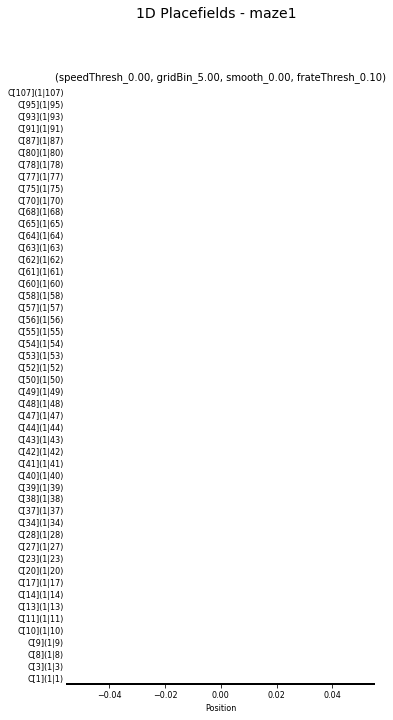

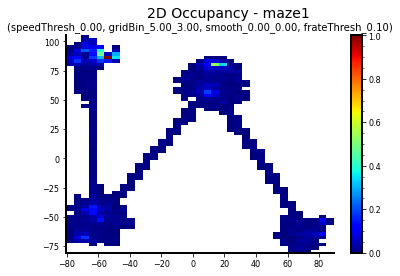

C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


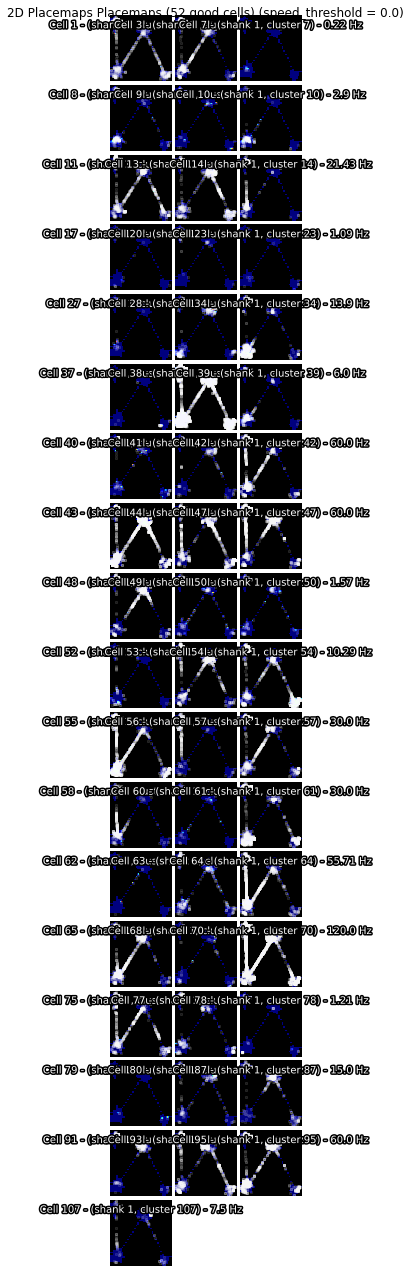

In [8]:
ax_pf_1D, occupancy_fig, active_pf_2D_figures, active_pf_2D_gs = plot_all_placefields(active_epoch_placefields1D, active_epoch_placefields2D, active_config, should_save_to_disk=should_save_to_disk)

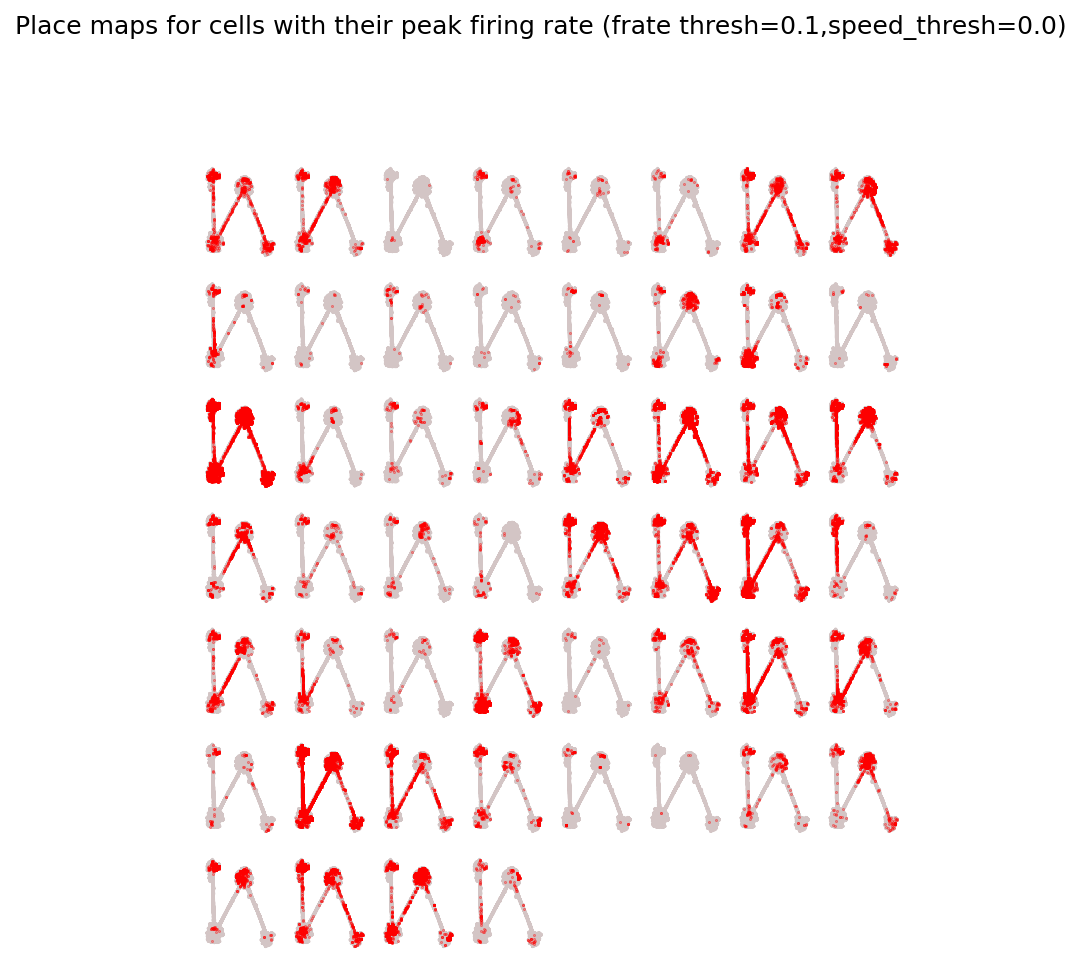

In [9]:
# active_epoch_placefields2D.plot_occupancy()
# active_epoch_placefields2D.plotRaw_v_time(1)
active_epoch_placefields2D.plot_raw() # Plots an overview of each cell all in one figure
a_fig = plt.gcf()
# a_fig.fig_size = (40, 40)
a_fig.dpi = 150

data_aspect_ratio: (0.9259259259259259, Width_Height_Tuple(width=175.0, height=189.0))
page_grid_sizes: [RowColTuple(num_rows=7, num_columns=8)]
resolution_multiplier: 1.0, required_figure_size: (64.0, 7.0)
page_idx: 0


C:\Users\Pho\anaconda3\envs\phoviz_test\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


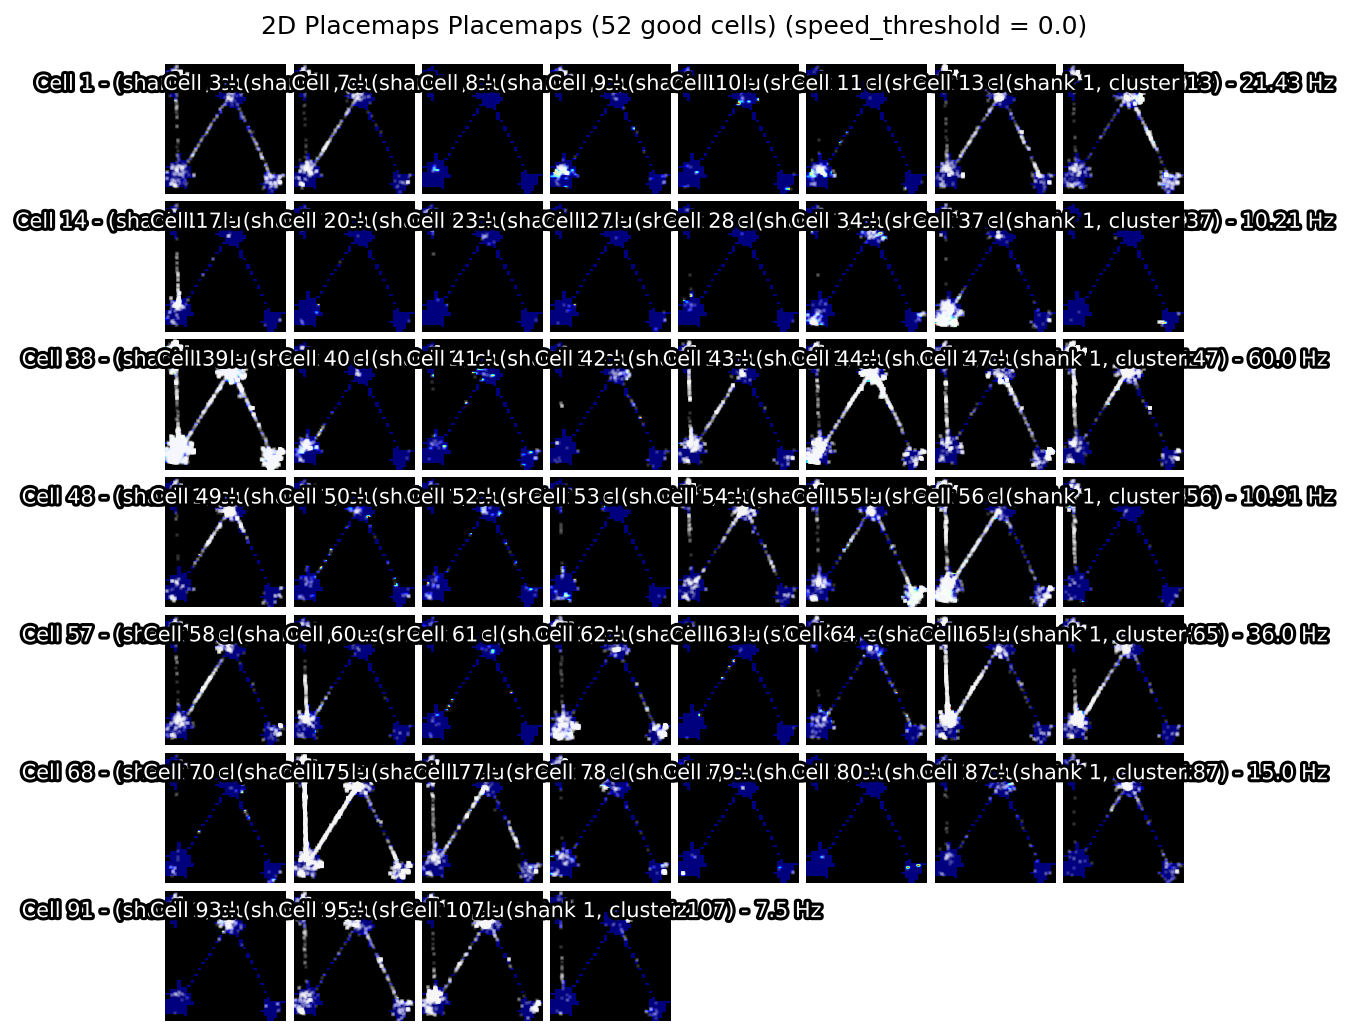

In [10]:
active_epoch_placefields2D.plot_ratemaps_2D() # figsize=(24,40)
plt.gcf().dpi = 150

## Main Spike/Placemap plotting:

# Plot Placemaps on 3D Plot

In [11]:
# from PhoGui.Panel.panel_placefield import build_all_placefield_output_panels, SingleEditablePlacefieldDisplayConfiguration, ActivePlacefieldsPlottingPanel
from PhoGui.InteractivePlotter.InteractivePlaceCellTuningCurvesDataExplorer import InteractivePlaceCellTuningCurvesDataExplorer

try: pActiveTuningCurvesPlotter
except NameError: pActiveTuningCurvesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipcDataExplorer = InteractivePlaceCellTuningCurvesDataExplorer(active_config, active_epoch_session, active_epoch_placefields2D, active_config.plotting_config.pf_colors, extant_plotter=pActiveTuningCurvesPlotter)
pActiveTuningCurvesPlotter = ipcDataExplorer.plot(pActiveTuningCurvesPlotter) # [2, 17449]

Applying custom Pyvista theme.
done.
No extant BackgroundPlotter
Creating a new BackgroundPlotter
num_curr_tuning_curves: 52
successfully set custom rgb key from separate R, G, B columns in dataframe.
self.params.debug_disable_all_gui_controls is True, so no gui controls will be built.


In [12]:

# def update_included_cell_ids(curr_unit_idx, show_spikes):
def update_included_cell_Indicies(included_cell_INDEXES, show_spikes=False):
    """ Only used for the old ActivePlacefieldsPlottingPanel-style panel """
    # included_cell_INDEXES = [curr_unit_idx]
    # included_cell_INDEXES = [ipcDataExplorer.get_cell_id_and_idx(cell_id=an_included_cell_ID)[0] for an_included_cell_ID in included_cell_ids]
    included_cell_ids = [ipcDataExplorer.get_neuron_id_and_idx(neuron_i=an_included_cell_idx)[1] for an_included_cell_idx in included_cell_INDEXES]
    # print(included_cell_ids)
    ipcDataExplorer.update_active_placefields(included_cell_INDEXES) # actives only the placefields that have aclu values (cell ids) in the included_cell_ids array.
    if show_spikes:
        ipcDataExplorer.update_active_spikes(np.isin(ipcDataExplorer.active_session.spikes_df['aclu'], included_cell_ids))
    else:
        ipcDataExplorer.update_active_spikes(np.isin(ipcDataExplorer.active_session.spikes_df['aclu'], []))

    ipcDataExplorer.gui['debug_console_widget'].add_line_to_buffer(f'cell_i: {included_cell_INDEXES}, cell_id: {included_cell_ids}')
    # pn.pane.Matplotlib(fig)

### Build Dynamic Panel Interactive Controls for configuring Placefields:

In [13]:
from PhoGui.Panel.panel_placefield import build_all_placefield_output_panels, SingleEditablePlacefieldDisplayConfiguration, ActivePlacefieldsPlottingPanel

class EndButtonPanel(object):
    debug_logging = False
    
    def __init__(self, pf_option_indicies=None, pf_option_selected_values=None, num_pfs=None, update_included_cell_Indicies_callback=None, **params):
        super(EndButtonPanel, self).__init__(**params)
        self.final_update_included_cell_Indicies_callback = None
        if update_included_cell_Indicies_callback is not None:
            if callable(update_included_cell_Indicies_callback):
                self.final_update_included_cell_Indicies_callback = update_included_cell_Indicies_callback

        # assert (self.final_update_included_cell_Indicies_callback is not None), "An update_included_cell_Indicies_callback(x) callback is needed."

    def btn_hide_all_callback(self, event):
        if self.debug_logging:
            print('EndButtonPanel.btn_hide_all_callback(...)')
        ipcDataExplorer.clear_all_spikes_included()
        ipcDataExplorer.update_active_placefields([])
        # self.on_hide_all_placefields()

    def btn_update_active_placefields(self, event):
        if self.debug_logging:
            print('EndButtonPanel.btn_update_active_placefields(...)')
        # updated_pf_options_list_ints = ActivePlacefieldsPlottingPanel.options_to_int(self.cross_selector.value) # convert to ints
        # self.on_update_active_placefields(updated_pf_options_list_ints)
        
    def panel(self):
        # Panel pane and widget objects:
        # Action Buttons:
        self.button_hide_all = pn.widgets.Button(name='Hide All', width_policy='min')
        self.button_hide_all.on_click(self.btn_hide_all_callback)
        self.button_update = pn.widgets.Button(name='Refresh', button_type='primary', width_policy='min')
        self.button_update.on_click(self.btn_update_active_placefields)
        return pn.Column(self.button_hide_all, self.button_update, margin=0, width_policy='min', width=70)
    
def build_panel_interactive_placefield_visibility_controls(ipcDataExplorer):
    out_panels = build_all_placefield_output_panels(ipcDataExplorer)
    end_button_panel_obj = EndButtonPanel()
    end_cap_buttons = end_button_panel_obj.panel()
    out_row = pn.Row(*out_panels, end_cap_buttons, height=120)
    occupancy_widget = ipcDataExplorer.occupancy_plotting_config.param
    return pn.panel(pn.Column(out_row, pn.Row(occupancy_widget)))

pane = build_panel_interactive_placefield_visibility_controls(ipcDataExplorer)
pane

_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...) 
_on_toggle_plot_visible_changed(...)

Column
    [0] Row(height=120)
        [0] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='1', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#843c39', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [1] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='3', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#964b47', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [2] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='7', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#a75b57', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [3] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='8', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#b96c69', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [4] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='9', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#ca7f7c', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [5] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='10', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#dc9491', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [6] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='11', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#edaaa7', width=60)
            [2] Row(background='red', height=25, width=60)
                [0] Toggle(margin=0, name='pf')
            [3] Row(background='green', height=25, width=60)
                [0] Toggle(margin=0, name='Spikes')
        [7] GridSpec(height=100, margin=0, ncols=3, nrows=4, sizing_mode='fixed', width=60)
            [0] Button(height=25, margin=0, name='13', sizing_mode='stretch_both', width=60, width_policy='min')
            [1] ColorPicker(height=25, margin=0, sizing_mode='fixed', value='#ffc2bf', width=60)
            [2] Ro

## Interactive 3D Spike and Behavior Browser: 

In [ ]:
import PhoGui
from PhoGui.InteractivePlotter.PhoInteractivePlotter import PhoInteractivePlotter
from PhoGui.InteractivePlotter.shared_helpers import InteractivePyvistaPlotterBuildIfNeededMixin
from PhoGui.InteractivePlotter.InteractivePlaceCellDataExplorer import InteractivePlaceCellDataExplorer

active_config.plotting_config.show_legend = True

try: pActiveInteractivePlaceSpikesPlotter
except NameError: pActiveInteractivePlaceSpikesPlotter = None # Checks variable p's existance, and sets its value to None if it doesn't exist so it can be checked in the next step
ipspikesDataExplorer = InteractivePlaceCellDataExplorer(active_config, active_epoch_session, extant_plotter=pActiveInteractivePlaceSpikesPlotter)
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)

In [ ]:
pActiveInteractivePlaceSpikesPlotter = ipspikesDataExplorer.plot(pActivePlotter=pActiveInteractivePlaceSpikesPlotter)